# Day 6, directed acyclic graph

Today we are given a tree, essentiallly a directed, acyclic graph. Trees can be undirected too, but since once node (body) orbits another, there is a clear direction.

The first task is to sum the distances from root body (the one object in the graph that doesn't orbit around other bodies) for all bodies in the graph. So we only need to traverse the graph, and for each new node add their depth $d_n$, defined as $d_{n-1} + 1$, to the total.

In [1]:
import aocd
data = aocd.get_data(day=6, year=2019)

In [2]:
from __future__ import annotations

from collections import deque
from typing import Dict, Iterable, Mapping, Optional, Set, Tuple

# A directed graph is a mapping of node names referencing a set of other node names
DGraph = Mapping[str, Set[str]]

def read_orbits(lines: Iterable[str]) -> DGraph:
    graph: Dict[str, Set[str]] = {}
    for line in lines:
        center, _, body = line.strip().partition(')')
        graph.setdefault(center, set()).add(body)
    return graph

def walk(graph: DGraph, root: str = 'COM') -> Iterable[Tuple[str, int, Optional[str]]]:
    """Walk a graph, yielding (name, depth, orbits) tuples
    
    name is a body in the graph, depth the number of steps it is removed from the root
    and orbits the name of the body it is orbiting around.
    
    """
    stack = deque([(root, 0, None)])
    while stack:
        body, depth, orbits = stack.pop()
        yield (body, depth, orbits)
        stack += ((b, depth + 1, body) for b in graph.get(body, ()))

def total_direct_and_indirect_orbits(graph: DGraph) -> int:
    return sum(d for _, d, _ in walk(graph))

part1_testinput = """\
COM)B
B)C
C)D
D)E
E)F
B)G
G)H
D)I
E)J
J)K
K)L
""".splitlines()
part1_testorbits = read_orbits(part1_testinput)
assert total_direct_and_indirect_orbits(part1_testorbits) == 42

## Visualisation

This is what the test tree looks like:

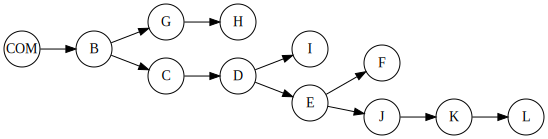

In [3]:
import subprocess
import graphviz
from IPython.display import display, Markdown

def plot_graph(
    graph: DGraph,
    root: str = 'COM',
    edge_attr: Optional[Mapping[str, str]] = None,
    node_attr: Optional[Mapping[str, str]] = None,
    **graph_attr: str
) -> graphviz.Digraph:
    dot = graphviz.Digraph('orbits',  strict=True)
    dot.attr(ratio="compress", **graph_attr)
    if edge_attr:
        dot.attr('edge', **edge_attr)
    node_attr = {"shape": "circle", "fixedsize": "true", **(node_attr or {})}
    dot.attr('node', **node_attr)
    orbiting: Set[str] = set.union(*graph.values()) - {root}
    with dot.subgraph(graph_attr={'rank': 'min'}) as startnodes:
        startnodes.node(root)
    with dot.subgraph() as endnodes:
        for body in orbiting - set(graph):
            endnodes.node(body)
    for centre, bodies in sorted(graph.items()):
        dot.edges((centre, b) for b in bodies)

    try:
        # attempt to process the graph through unflatten, if available
        result = subprocess.run(["unflatten", "-l", "4"], input=dot.source, capture_output=True, encoding='utf8')
        if result.returncode == 0:
            dot = graphviz.Source(result.stdout)
    except OSError:
        pass
        
    return dot

display(Markdown("## Visualisation\n\nThis is what the test tree looks like:"))
plot_graph(part1_testorbits, rankdir='LR', size="8,3")

In [4]:
orbits = read_orbits(data.splitlines())
print("Part 1:", total_direct_and_indirect_orbits(orbits))

Part 1: 142915


## Visualisation

The puzzle input data is a lot larger:

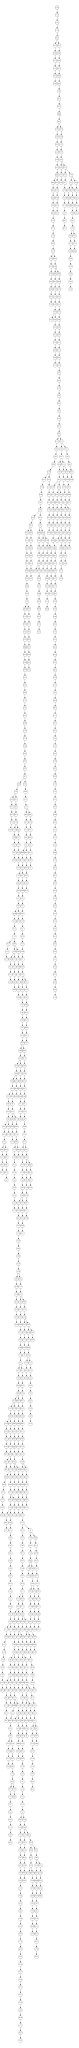

In [5]:
display(Markdown("## Visualisation\n\nThe puzzle input data is a lot larger:"))
plot_graph(orbits, nodesep="0.03", node_attr={"fontsize": "10.0", "margin": "0.07,0.045"})

## Part 2, common ancestor finding

We are basically tasked with finding a common ancestor for both the `YOU` and `SAN` nodes, and add up the relative depths from that common ancestor. In the test input in the description, that common ancestor is `D`, and `YOU` and `SAN` orbit around objects that are at relative depths 1 an d3 from that common ancestor, hence the answer being 4.

We can find the common ancestor by inverting our graph (but *keeping* the depth information we already calculated for part 1), and then traversing up the graph for both `YOU` and `SAN` until you find a common body at the same depth; we'll have to first traverse up the one object that's deepest into the tree to make it easier to find the common ancestor at the same depth. Then just take the relative depths and we are done!

E.g. for the test input, `YOU` orbits `(K, 6)`, and `SAN` orbits `(I, 4)`. We move `YOU` to an orbit at depth 4 first, which takes 2 steps, to `(E, 4)`. That's not the same body as `(I, 4)`, so traverse to the next body for both, and we arrive at `(D, 3)` for both. Our answer is then `(6 - 3) + (4 - 3) == 4`.

In [6]:
from itertools import islice

def minimum_orbital_transfers(graph: DGraph, from_: str = 'YOU', to: str = 'SAN') -> int:
    # (d)epth is for orbiting (b)ody, so for (o)rbited, depth is d - 1
    orbiting: Dict[str, Tuple[str, int]] = {b: (o, d - 1) for b, d, o in walk(graph) if o is not None}
    
    def traverse(pair: Tuple[str, int]) -> Iterator[Tuple[str, int]]:
        """Traverse orbiting bodies inwards"""
        while pair:
            yield pair
            pair = orbiting.get(pair[0])

    traversals = traverse(orbiting[from_]), traverse(orbiting[to])
    positions = [next(t) for t in traversals]
    start_depths = [d for _, d in positions]

    while positions[0] != positions[1]:
        # if not equal, only traverse the furtherst
        if positions[0][1] > positions[1][1]:
            positions[0] = next(traversals[0])
        elif positions[0][1] < positions[1][1]:
            positions[1] = next(traversals[1]) 
        else:
            positions = [next(t) for t in traversals]
    common_depth = positions[0][1]
    return sum(d - common_depth for d in start_depths)

part2_testinput = part1_testinput + ["K)YOU", "I)SAN"]
part2_testorbits = read_orbits(part2_testinput)
assert minimum_orbital_transfers(part2_testorbits) == 4

In [7]:
print("Part 2:", minimum_orbital_transfers(orbits))

Part 2: 283
